In [1]:
"""
  A manager that facilitates reading and writing files to GCP Storage
"""
import logging
import os
import subprocess
from io import BytesIO
from typing import List, Dict, Callable, Tuple, Union
from mypy_extensions import TypedDict

from google.cloud import storage # type: ignore

def get_path_prefix(root_dir: str, relative_path: str) -> str:
    prefix = ''
    if root_dir:
        prefix = root_dir.rstrip('/') + '/'

    if relative_path and relative_path != '/':
        prefix = prefix + relative_path.strip('/') + '/'

    return prefix

class PathNode(TypedDict, total=False):
    name: str
    type: str
    size: float
        
class GCPStorageManager(object):

    def __init__(self, storage_details: Dict, verbose: bool) -> None:
        self._bucket_name = storage_details.get('bucket')
        self._root_dir = storage_details.get('root')
        self.client = storage.Client()
        self.verbose = verbose

    def _abs_path(self, rel_path: str) -> str:
        if not self._root_dir:
            return rel_path

        return os.path.join(self._root_dir, rel_path)

    def _build_current_url(self) -> str:
        if self._root_dir:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name + "/" + self._root_dir
        else:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name

    def get_root_dir(self) -> str:
        return self._root_dir

    def get_storage_details(self) -> Dict:
        return {
            'provider': file_utils.ProviderList.GCP_STORAGE,
            'bucket': self._bucket_name,
            'root': self._root_dir
        }

    def get_sync_login_command(self, env_vars: Dict) -> List[str]:
        return None

    def get_sync_url(self, path: str) -> str:
        if not path or path == '/':
            abs_path = self._root_dir
        else:
            abs_path = self._abs_path(path)
        return f'gs://{self._bucket_name}/{abs_path}'

    def get_sync_command(self, src_dir: str, remote_path: str) -> Callable:

        def sync_call() -> Tuple[int, str]:
            cmd = ['gsutil', 'rsync', '-r', src_dir, self.get_sync_url(remote_path)]
            p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = p.communicate()
            err_code = 0
            stderr_val = ''

            if p.returncode != 0:
                logging.error('Copy response is: {}'.format(stderr.decode('utf-8')))
                stderr_val = stderr.decode('utf-8')
                err_code = p.returncode

            return err_code, stderr_val

        return sync_call

    def rm_file(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        path = self._abs_path(relative_path)
        blob = bucket.blob(path)
        logging.info('Deleting file at ' + path)
        blob.delete()

    def rm_dir(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        prefix = get_path_prefix(self._root_dir, relative_path)
        blob = bucket.blob(prefix)
        logging.info('Deleting files at ' + prefix)
        blob.delete()

    def read_content(self, path: str, throw_exception: bool, read_range: str = None, streaming: bool = False) -> bytes:
        try:
            path = self._abs_path(path)
            bucket = self.client.bucket(self._bucket_name)
            blob = bucket.blob(path)
            result = blob.download_as_bytes()

            if self.verbose:
                logging.info(f"Downloading content from {self._build_current_url()}/{path}")

            return result
        except Exception as e:
            raise

    #def gen_presigned_url(self, path: str) -> str:
    #    # dask and other frameworks explicit s3 link rather than a byte stream or contet (e.g. s3://bucket/foo.csv)
    #    return self._s3.generate_presigned_url('get_object',
    #                                           Params={'Bucket': self._bucket_name, 'Key': self._abs_path(path)})

    # Checks to see if the job directory exists.  No side-effects.
    def check_dir_exists(self, path: str) -> bool:
        # Create the prefix for this particular job.
        exists = False
        prefix = get_path_prefix(self._root_dir, path)
        blobs = list(self.client.list_blobs(
            self._bucket_name, prefix=prefix
        ))
        if len(blobs) > 0:
            exists = True

        return exists

    def _download_content(self, remote_path: str) -> bytes:
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading content from {self._build_current_url()}/{remote_path}")

        fileobj = BytesIO()
        blob.download_to_file(fileobj)
        return fileobj.getvalue()

    def download_file(self, remote_path: str, file_name: str) -> None:
        # Move references to large data items across folders
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading file {self._build_current_url()}/{remote_path} to {file_name}")

        dirname = os.path.dirname(file_name)

        if dirname:
            # Only create a directory if it's not ''
            if not os.path.exists(dirname):
                os.makedirs(dirname)

        blob.download_to_filename(file_name)

    def download_and_unzip(self, remote_path: str, local_dir: str) -> None:
        zip_bytes = self._download_content(remote_path)
        file_utils.unzip_into_dir(zip_bytes, local_dir)

    def download_dir(self, remote_path: str, local_path: str) -> int:
        nFiles = 0
        if self.verbose:
            logging.info("Downloading folder: " + remote_path + " to " + local_path)

        prefix = file_utils.get_path_prefix(self._root_dir, remote_path)
        for blob in self.client.list_blobs(self._bucket_name, prefix=prefix):
            if blob.name.endswith('/'):
                continue

            rel_path = os.path.relpath(blob.name, prefix)
            dest_pathname = os.path.join(local_path, rel_path)

            if not os.path.exists(os.path.dirname(dest_pathname)):
                os.makedirs(os.path.dirname(dest_pathname))

            if self.verbose:
                logging.info(f"Downloading file {blob.name} to {dest_pathname}")

            blob.download_to_filename(dest_pathname)  # Download
            nFiles += 1

        return nFiles

    def upload_content(self, content: bytes, file_name: str) -> None:
        # Uploads file content to a specific filename location
        bucket = self.client.bucket(self._bucket_name)
        if self.verbose:
            logging.info(f"Uploading content to {self._build_current_url()}/{file_name}")

        blob = bucket.blob(self._abs_path(file_name))
        blob.upload_from_file(BytesIO(content))

    def list_directory(self, path: str, with_size: bool = False) -> Dict:
        prefix = get_path_prefix(self._root_dir, path)
        bucket = self.client.bucket(self._bucket_name)
        blobs = bucket.list_blobs(prefix=prefix)
        nodes = []
        for blob in blobs:
            if blob.name.endswith('/'):
                nodes.append(PathNode(name=os.path.basename(blob.name[:-1]), type='folder'))
            else:
                nodes.append(PathNode(name=os.path.basename(blob.name), type='file'))

        return {
            'nodes': nodes
        }


In [2]:
import os

from dotenv import load_dotenv
load_dotenv(verbose=True)

print(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'))

/Users/warren/sweat-equity-ventures/bespoke/flowhub_gcp_credentials.json


In [3]:
manager = GCPStorageManager({
    'bucket': 'partnerships-data-reporting',
    'root': ''
}, verbose=True)

In [4]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [5]:
import json
import pandas as pd
directory_contents = manager.list_directory('')['nodes']

In [6]:
company_ids_set = set([])

for file_metadata in directory_contents:
    file_name = file_metadata['name']
    # Company locations file case.
    if '_locations.csv' in file_name:
        company_id = file_name.replace('_locations.csv', '')
        company_ids_set.add(company_id)

company_ids_count = len(list(company_ids_set))
print(f'There are {company_ids_count} companies in the dataset')

There are 172 companies in the dataset


In [8]:
company_location_ids_set = set([])

for index, company_id in enumerate(company_ids_set):
    try:
        locations_csv_string = manager.read_content(f'{company_id}/{company_id}_locations.csv', throw_exception=True)
        locations_io = StringIO(locations_csv_string.decode("utf-8"))
        locations_dataframe = pd.read_csv(locations_io)
        for location_index in locations_dataframe.index:
            location_id = locations_dataframe['locationId'][location_index]
            location_state = locations_dataframe['state'][location_index]
            company_location_ids_set.add((company_id, location_id, location_state))
    except:
        print(f'[{index + 1}] An exception occurred for company ({company_id}, {location_id}, {location_state})')

company_location_ids_count = len(list(company_location_ids_set))
print(f'There are {company_location_ids_count} company locations in the dataset')

[134] An exception occurred for company (guNh9fyGuttgXAXsj, H3ZmnEr9cJwLp69KF, OR)
[159] An exception occurred for company (5nMPQfwSXPKWoX3yQ, JL5zpyFxo7J3rHxZK, OR)
There are 339 company locations in the dataset


In [9]:
# (company_id, location_id, location_sales_dataframe)
company_location_dataframes = []

for index, company_location_tuple in enumerate(list(company_location_ids_set)):
    company_id, location_id, location_state = company_location_tuple
    print(f'[{index + 1}] Downloading dataframes for location ({company_id}, {location_state})')

    try:
        location_sales_csv_string = manager.read_content(f'{company_id}/{location_id}/{location_id}_sales.csv', throw_exception=True)
        location_sales_io = StringIO(location_sales_csv_string.decode("utf-8"))
        location_sales_dataframe = pd.read_csv(location_sales_io)
        
        location_inventory_csv_string = manager.read_content(f'{company_id}/{location_id}/{location_id}_inventory.csv', throw_exception=True)
        location_inventory_io = StringIO(location_inventory_csv_string.decode("utf-8"))
        location_inventory_dataframe = pd.read_csv(location_inventory_io)
## here 2nd argument
        company_location_dataframes.append((company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe))
    except:
        print(f'[{index + 1}] An exception occurred for location ({company_id}, {location_id}, {location_state})')

company_location_dataframes_count = len(list(company_location_dataframes))
print(f'There are {company_location_dataframes_count} company location dataframes in the dataset')

[1] Downloading dataframes for location (FuDLDjBXzkEPPQxZD, MA)
[2] Downloading dataframes for location (tckhvuyuYrEJAD8c8, OR)
[3] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[4] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[5] Downloading dataframes for location (ySB2RKAtEDYKERK9J, MA)
[6] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[7] Downloading dataframes for location (KypyS8kNFhSPZxv7q, CO)
[8] Downloading dataframes for location (hbTCMydA4w2TnGqHE, OR)


/Users/warren/venvs/bespoke/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[9] Downloading dataframes for location (HK4Y9A5LobdH4Jw9f, CO)
[10] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[11] Downloading dataframes for location (tckhvuyuYrEJAD8c8, OR)
[12] Downloading dataframes for location (s4fnrie58B29225jc, MI)


/Users/warren/venvs/bespoke/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[13] Downloading dataframes for location (pJRQ5CqncC9xk8bdy, CA)
[14] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[15] Downloading dataframes for location (jXQzYY9rsss3mHoFw, CA)
[16] Downloading dataframes for location (7Grxab9AL8HbnNcCn, CO)
[17] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[18] Downloading dataframes for location (gmAmheWQLfWvhg7aF, CO)
[19] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[20] Downloading dataframes for location (7TXXyFaNqaygYcoZB, CA)
[21] Downloading dataframes for location (o46tyNKeC4xHZeh7h, CO)
[22] Downloading dataframes for location (DytS8HNkT37Lo5AXD, MI)
[23] Downloading dataframes for location (dPBnHGGKDN7BoewSb, CO)
[24] Downloading dataframes for location (rK3atC7axuLcz3iRB, OR)
[25] Downloading dataframes for location (XQak5YK9eZfXYhKgJ, OR)
[26] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[27] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[28] Downloading datafram

/Users/warren/venvs/bespoke/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[60] Downloading dataframes for location (hPzYzThkKMuQrF9Q2, CO)
[61] Downloading dataframes for location (EHYBJyTX2dd8CaBeL, MA)
[62] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[63] Downloading dataframes for location (vYH2STtcMXFgXEvWy, CA)
[64] Downloading dataframes for location (iGQ7QnShCTC4QuRxt, MI)
[65] Downloading dataframes for location (7R5MBJ2wAH328M9P7, MI)
[66] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[67] Downloading dataframes for location (MRmiGXv584QfQL5pp, OR)
[68] Downloading dataframes for location (TETLayDXwuGSrkANd, CO)
[69] Downloading dataframes for location (KkyhzzHqgJDFWPM9n, CA)
[70] Downloading dataframes for location (kj9TDK47e77JQ9hwb, CA)
[71] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[72] Downloading dataframes for location (P63pMT9HvTtdmhWcL, MI)
[73] Downloading dataframes for location (KkyhzzHqgJDFWPM9n, CA)
[74] Downloading dataframes for location (4mtWSXbcCsL23BCiu, CA)
[75] Downloading datafram

/Users/warren/venvs/bespoke/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,14,24,27,28,38,43,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[176] Downloading dataframes for location (ALttWoeagztP6As4G, MA)
[177] Downloading dataframes for location (wiyY5tNikq6WRPQ6E, MI)
[178] Downloading dataframes for location (czyNjjNhCHky7mjfu, MI)
[179] Downloading dataframes for location (7SRQ7Z7xuN5EGXGSu, CA)
[180] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[181] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[182] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[183] Downloading dataframes for location (7SRQ7Z7xuN5EGXGSu, CA)
[184] Downloading dataframes for location (iGQ7QnShCTC4QuRxt, MI)
[185] Downloading dataframes for location (W9FX7xfES6pZPg4o8, MA)
[186] Downloading dataframes for location (P63pMT9HvTtdmhWcL, MI)
[187] Downloading dataframes for location (3Zqksvn9wb6dz9sjX, MI)
[188] Downloading dataframes for location (GnFCdPCTJTqhBa5bm, MI)
[189] Downloading dataframes for location (auwhtSe4TrkRv2ucM, OR)
[190] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[191] Down

In [10]:
state_to_count = {}

for company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe in company_location_dataframes:
    if location_state not in state_to_count:
        state_to_count[location_state] = 0
    state_to_count[location_state] += 1

state_to_count

{'MA': 16, 'OR': 105, 'CO': 98, 'MI': 67, 'CA': 48, 'AZ': 1, 'AL': 2}

In [13]:
for index, company_location_dataframe_tuple in enumerate(company_location_dataframes):
    company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe = company_location_dataframe_tuple
    print(index, company_id, location_id, location_state, location_sales_dataframe.shape, location_inventory_dataframe.shape)

0 FuDLDjBXzkEPPQxZD TgLFQQcK4NiY8unCE MA (129769, 35) (927, 69)
1 tckhvuyuYrEJAD8c8 RJitCGqvumPSKkHHL OR (34252, 35) (1317, 70)
2 HexjEZWy6f7vEeTMT xKD2bbjm7zRRpsBPd OR (345622, 35) (1428, 69)
3 HexjEZWy6f7vEeTMT skZWxv3vyM5SpdaKW OR (237402, 35) (1145, 69)
4 ySB2RKAtEDYKERK9J 2t3guxpfanCWqycA6 MA (39505, 35) (870, 69)
5 LzvWGesZNXbYjfTKC QauoPJCMz9eR4FrXJ OR (161319, 35) (661, 70)
6 KypyS8kNFhSPZxv7q hqoDkhKFbRGdjaC9Z CO (26261, 35) (956, 70)
7 hbTCMydA4w2TnGqHE mN2gXpCGvAx4aMbit OR (447502, 35) (2508, 70)
8 HK4Y9A5LobdH4Jw9f yzHFJJmFEkC76vTjx CO (27, 35) (60, 70)
9 HexjEZWy6f7vEeTMT sfaqG9ujHRuML6J2c OR (7187, 35) (806, 69)
10 tckhvuyuYrEJAD8c8 hC84vcN7zXqNvofR9 OR (131857, 35) (1810, 70)
11 s4fnrie58B29225jc bhKv2q34nZ3pwig9G MI (393376, 35) (1296, 70)
12 pJRQ5CqncC9xk8bdy bmJuhcYDiqAcbj6Ze CA (109676, 35) (500, 69)
13 HexjEZWy6f7vEeTMT YHbBWDdfqFLrH6fsm OR (410, 35) (116, 33)
14 jXQzYY9rsss3mHoFw uxnKu8ymALAec9xxR CA (6312, 35) (646, 69)
15 7Grxab9AL8HbnNcCn J4qscTeHW28gWBxju CO (1

In [14]:
test = company_location_dataframes[43][3]
test_inv = company_location_dataframes[43][4]

In [15]:
test.columns.unique()

Index(['Unnamed: 0', 'saleId', 'itemId', 'createdAt', 'updatedAt', 'clientId',
       'locationId', 'customerType', 'orderType', 'orderSource', 'voided',
       'totalFeesInDollars', 'sku', 'category', 'brand', 'productName',
       'strainName', 'reportUOM', 'productType', 'totalTaxInDollars',
       'subtotalInDollars', 'itemTotalInDollars', 'costInDollars',
       'costPerGramInDollars', 'title1', 'title2', 'totalGramsSold',
       'numberOfItems', 'DiscountAmountInDollars', 'meanSubtotalInDollars',
       'meanCostInDollars', 'meanCostPerGramInDollars',
       'meanNumberOfItemsSold', 'meanProfit', 'meanProfitBulk'],
      dtype='object')

In [ ]:
#test.to_csv('Wjgbcenow3oSALsgJ(CA).csv')

# PROCESS DATA FRAMES

In [99]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
pd.set_option("display.max_columns", None)


In [100]:
def pre_process_df(df,loc_id,loc_state):
    df = (
        df
        .assign(**{"createdAt": lambda df_: pd.to_datetime(df_['createdAt'])})
        .assign(**{"year_month": lambda df_: df_['createdAt'].dt.strftime('%Y-%m')})
        .assign(**{"per_unit_price": lambda df_: df_['subtotalInDollars'] / df_['numberOfItems']})
        .assign(**{"per_unit_cost": lambda df_: df_['costInDollars'] / df_['numberOfItems']})
        .replace('None', np.nan).fillna(0)
    )
    
    #exclude cost < $1.0
    df_low_cost = df[df['costInDollars'] < 1.0]
    df_non_low_cost = df[df['costInDollars'] >= 1.0]
    perc_low_cost = df_low_cost.shape[0] / df.shape[0]
    
    #exclude high unit sales price
    df_high_sale = df_non_low_cost[df_non_low_cost['per_unit_price'] > 500]
    df_non_high_sale =  df_non_low_cost[df_non_low_cost['per_unit_price'] <= 500]
    perc_high_sale = df_high_sale.shape[0] / df_non_low_cost.shape[0]
    
    #exclude high unit cost 
    df_high_cost = df_non_high_sale[df_non_high_sale['per_unit_cost'] > 500]
    df_non_high_cost =  df_non_high_sale[df_non_high_sale['per_unit_cost'] <= 500]
    perc_high_cost = df_high_cost.shape[0] / df_non_high_sale.shape[0]
    
    #exclude category = Accessory
    #df_accessory = df_non_high_cost[df_non_high_cost['category'] == 'Accessory']
    #df_non_accessory = df_non_high_cost[(df_non_high_cost['category'] != 'Accessory')]
    #perc_accessory = df_accessory.shape[0] / df_non_high_cost.shape[0]
    # cogs
    cogs = df_non_high_cost[['year_month','subtotalInDollars','costInDollars']].groupby('year_month').sum()
    cogs['profit'] = cogs['subtotalInDollars'] - cogs['costInDollars']
    cogs['margin_perc'] = cogs['profit'] / cogs['subtotalInDollars']
    cogs['location_id'] = loc_id
    cogs['location_state'] = loc_state
    return cogs.reset_index(),perc_low_cost,perc_high_sale,perc_high_cost
    

In [101]:
res = []
low_cost_trim_perc= []
high_sale_trim_perc = []
high_cost_perc = []
 #company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe
for company_id, location_id, location_state, df, inv_df in tqdm(company_location_dataframes):
    if len(df) == 0:
        low_cost_trim_perc.append(np.nan)
        high_sale_trim_perc.append(np.nan)
        high_cost_perc.append(np.nan)
        continue
    res.append(pre_process_df(df, location_id, location_state)[0])
    low_cost_trim_perc.append(pre_process_df(df, location_id, location_state)[1])
    high_sale_trim_perc.append(pre_process_df(df, location_id, location_state)[2])
    high_cost_perc.append(pre_process_df(df, location_id, location_state)[3])

100%|██████████| 178/178 [09:12<00:00,  3.10s/it]


In [103]:
low_cost_trim_perc_df = pd.DataFrame(low_cost_trim_perc)
low_cost_trim_perc_df.columns = ['low_cost_trim_perc']
high_sale_trim_perc_df = pd.DataFrame(high_sale_trim_perc)
high_sale_trim_perc_df.columns = ['high_sale_trim_perc']
high_cost_trim_perc_df = pd.DataFrame(high_cost_perc)
high_cost_trim_perc_df.columns = ['high_cost_trim_perc']

In [104]:
low_cost_trim_perc_df.describe()

,low_cost_trim_perc
count,164.000000
mean,0.093334
std,0.149011
min,0.000000
25%,0.014457
50%,0.033666
75%,0.090834
max,0.990596


In [105]:
high_sale_trim_perc_df.describe()

,high_sale_trim_perc
count,164.000000
mean,0.001055
std,0.004728
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000021
max,0.040546


In [106]:
high_cost_trim_perc_df.describe()

,high_cost_trim_perc
count,164.000000
mean,0.000161
std,0.000513
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000027
max,0.003662


In [ ]:
# 178 company locations
# 1 failed download -> 177 locations
# 15 empty df


In [107]:
final_df = pd.concat(res).reset_index(drop=True)

In [108]:

final_df[final_df['location_id'] == 'ofeoiXgSPuM6PCyaN']

,year_month,subtotalInDollars,costInDollars,profit,margin_perc,location_id,location_state
0,2021-01,50724.04,21406.86,29317.18,0.577974,ofeoiXgSPuM6PCyaN,CO
1,2021-02,187656.76,87471.99,100184.77,0.533872,ofeoiXgSPuM6PCyaN,CO
2,2021-03,305790.83,162890.76,142900.07,0.467313,ofeoiXgSPuM6PCyaN,CO
3,2021-04,340649.03,191337.24,149311.79,0.438316,ofeoiXgSPuM6PCyaN,CO
4,2021-05,350242.02,188292.91,161949.11,0.462392,ofeoiXgSPuM6PCyaN,CO
5,2021-06,292731.74,166076.36,126655.38,0.432667,ofeoiXgSPuM6PCyaN,CO
6,2021-07,390098.39,201549.94,188548.45,0.483336,ofeoiXgSPuM6PCyaN,CO
7,2021-08,390863.68,185554.91,205308.77,0.525270,ofeoiXgSPuM6PCyaN,CO
8,2021-09,385927.14,177407.87,208519.27,0.540307,ofeoiXgSPuM6PCyaN,CO
9,2021-10,384830.47,178398.46,206432.01,0.536423,ofeoiXgSPuM6PCyaN,CO


In [109]:
#final_df.to_csv('flowhub_sales_final_df_v0.csv')

## Count

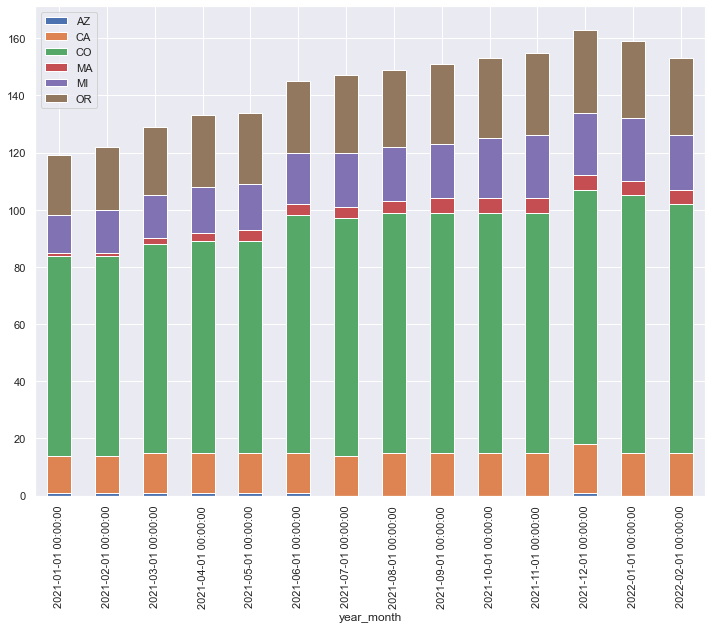

In [110]:
state_count = final_df[['location_state','location_id','year_month']].groupby(['location_state','year_month']).count().unstack().T.reset_index()
state_count.index = pd.to_datetime(state_count['year_month'])

ax = state_count.plot(kind='bar', stacked=True,figsize = (12,9))
ax.legend(loc = 2)

# Distribution of margin & sales by states

In [113]:
#final_df.to_csv('flowhub_location_analysis_0203.csv')

In [18]:
# distribution of margin
margin_distr = final_df.groupby(['location_state','year_month'])['margin_perc'].describe().reset_index()
margin_distr['year_month'] = pd.to_datetime(margin_distr['year_month'])

In [19]:
# distribution of margin
sales_distr = final_df.groupby(['location_state','year_month'])['subtotalInDollars'].describe().reset_index()
sales_distr['year_month'] = pd.to_datetime(sales_distr['year_month'])

In [20]:
sales_distr[sales_distr['location_state'] == 'OR']

,location_state,year_month,count,mean,std,min,25%,50%,75%,max
63,OR,2021-01-01,21.0,309717.676905,556637.124479,32055.70,80462.9200,164345.060,234827.8000,2643282.70
64,OR,2021-02-01,22.0,263440.491591,445283.292389,28555.94,88272.9900,150553.780,209356.8525,2167737.36
65,OR,2021-03-01,24.0,309005.415833,543354.266219,77.45,101342.0250,183237.575,254776.9375,2730445.66
66,OR,2021-04-01,25.0,312189.224400,527337.226843,7387.54,113108.2600,182169.670,271779.2100,2700592.50
67,OR,2021-05-01,25.0,297048.264000,473715.703537,24522.53,109073.0500,178149.560,258477.7400,2415218.48
68,OR,2021-06-01,25.0,256472.546200,399022.802071,23054.86,112978.3200,149113.250,227746.8800,2036554.01
69,OR,2021-07-01,27.0,262533.976667,422412.551281,141.43,84788.1000,148935.580,235075.4050,2206132.51
70,OR,2021-08-01,27.0,253794.797222,400694.147777,27425.05,78123.3600,160249.820,230288.0150,2086896.78
71,OR,2021-09-01,28.0,241006.303571,394507.638790,1644.64,62910.7325,137023.445,218904.1450,2072866.00
72,OR,2021-10-01,28.0,248733.277500,401834.975952,20500.16,70406.1750,129310.800,216690.8675,2094996.17


In [21]:
#margin_distr.to_csv('monthly_margin_distribution_by_state_0127.csv')

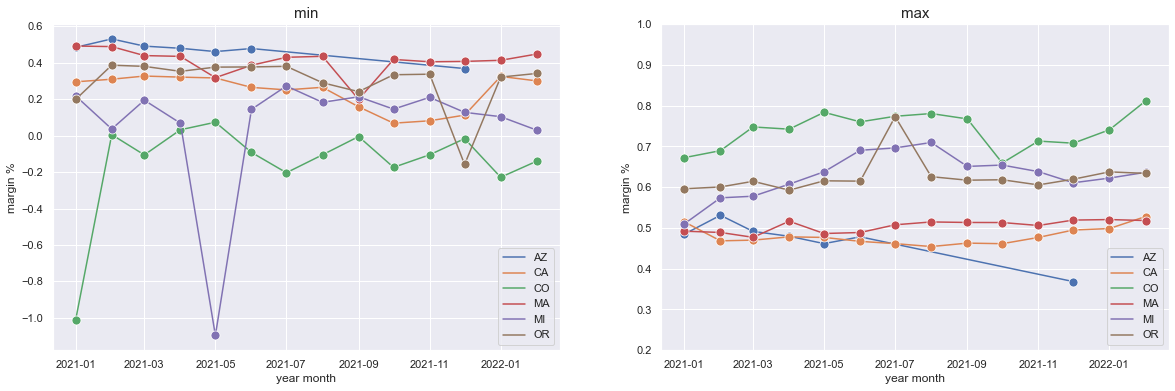

In [25]:
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="min", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("min", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="year_month", y="max", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
#plt.ylim([0.3, 0.6])
ax[1].legend(loc = 4)
ax[1].set_title("max", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


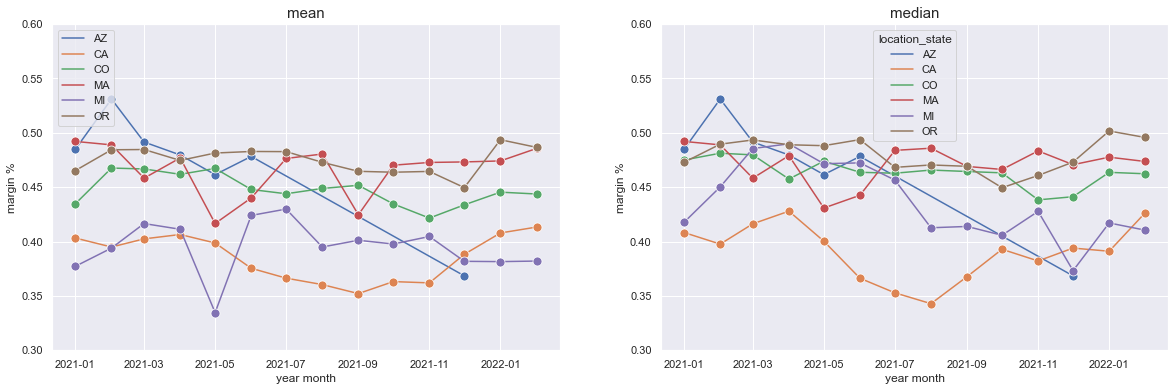

In [23]:
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="mean", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].set(ylim=(0.3, 0.6))
ax[0].set_title("mean", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
ax[0].legend(loc = 2)
sns.lineplot(data=margin_distr, x="year_month", y="50%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].set(ylim=(0.3, 0.6))
ax[1].set_title("median", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
sns.set(rc={'figure.figsize':(20,6)})


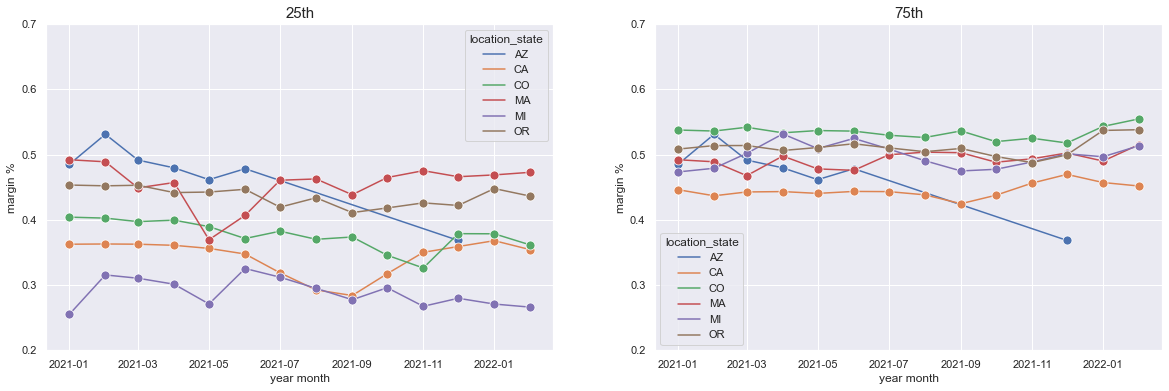

In [24]:
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="25%", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].set(ylim=(0.2, 0.7))
ax[0].set_title("25th", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="year_month", y="75%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].set(ylim=(0.2, 0.7))
ax[1].set_title("75th", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
sns.set(rc={'figure.figsize':(20,6)})


# by product category

In [ ]:
final_df.head()

In [ ]:
def pre_process_df_by_cat(df,loc_id,loc_state):
    df = (
        df
        .assign(**{"createdAt": lambda df_: pd.to_datetime(df_['createdAt'])})
        .assign(**{"year_month": lambda df_: df_['createdAt'].dt.strftime('%Y-%m')})
        .assign(**{"per_unit_price": lambda df_: df_['subtotalInDollars'] / df_['numberOfItems']})
        .assign(**{"per_unit_cost": lambda df_: df_['costInDollars'] / df_['numberOfItems']})
        .replace('None', np.nan).fillna(0)
    )
    
    #exclude cost < $1.0
    df_low_cost = df[df['costInDollars'] < 1.0]
    df_non_low_cost = df[df['costInDollars'] >= 1.0]
    perc_low_cost = df_low_cost.shape[0] / df.shape[0]
    
    #exclude high unit sales price
    df_high_sale = df_non_low_cost[df_non_low_cost['per_unit_price'] > 500]
    df_non_high_sale =  df_non_low_cost[df_non_low_cost['per_unit_price'] <= 500]
    perc_high_sale = df_high_sale.shape[0] / df_non_low_cost.shape[0]
    
    #exclude high unit cost 
    df_high_cost = df_non_high_sale[df_non_high_sale['per_unit_cost'] > 500]
    df_non_high_cost =  df_non_high_sale[df_non_high_sale['per_unit_cost'] <= 500]
    perc_high_cost = df_high_cost.shape[0] / df_non_high_sale.shape[0]
    
    #exclude category = Accessory
    #df_accessory = df_non_high_cost[df_non_high_cost['category'] == 'Accessory']
    #df_non_accessory = df_non_high_cost[(df_non_high_cost['category'] != 'Accessory')]
    #perc_accessory = df_accessory.shape[0] / df_non_high_cost.shape[0]
    
    # cogs
    cogs = df_non_high_cost[['year_month','category','subtotalInDollars','costInDollars']].groupby(['year_month','category']).sum()
    cogs['profit'] = cogs['subtotalInDollars'] - cogs['costInDollars']
    cogs['margin_perc'] = cogs['profit'] / cogs['subtotalInDollars']
    cogs['location_id'] = loc_id
    cogs['location_state'] = loc_state
    return cogs.reset_index(),perc_low_cost
    

In [ ]:
res_cat = []

for company_id, location_id, location_state, df, inv_df in tqdm(company_location_dataframes):
    if len(df) == 0:
        continue
    res_cat.append(pre_process_df_by_cat(df, location_id, location_state)[0])

In [ ]:
final_df_cat = pd.concat(res_cat).reset_index(drop=True)

In [ ]:
final_df_cat

In [ ]:
#cat_sales_distr = final_df_cat.groupby(['category','year_month'])['costInDollars'].describe().reset_index()
#cat_margin_distr['year_month'] = pd.to_datetime(cat_margin_distr['year_month'])

In [ ]:
ex = final_df_cat[final_df_cat['location_id'] == '6EAiLXwCs9wfXHbgG']

In [ ]:
ex

In [ ]:
cat_by_state = ex[['category','subtotalInDollars','year_month']].groupby(['year_month','category']).sum().reset_index()

In [ ]:
cat_by_state[cat_by_state['category'] == 'PackedBud']

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
#palette = sns.color_palette("Paired_r",15)
ax = sns.barplot(x="year_month", y="subtotalInDollars", hue="category", data=cat_by_state)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel ("median margin %")
ax.set_ylabel ("location state")

In [ ]:
cat_by_state[cat_by_state['location_state'] == 'CA'].sort_values(by = 'margin_perc', ascending = False)

In [ ]:
cat_by_state[cat_by_state['location_state'] == 'CO'].sort_values(by = 'margin_perc', ascending = False)

In [ ]:
cat_by_state[cat_by_state['location_state'] == 'MA'].sort_values(by = 'margin_perc', ascending = False)

In [ ]:
cat_by_state[cat_by_state['location_state'] == 'MI'].sort_values(by = 'margin_perc', ascending = False)

In [ ]:
cat_by_state[cat_by_state['location_state'] == 'OR'].sort_values(by = 'margin_perc', ascending = False)

# What each state is selling?

In [ ]:
def pre_process_df_by_state(df,loc_id,loc_state):
    df = (
        df
        .assign(**{"createdAt": lambda df_: pd.to_datetime(df_['createdAt'])})
        .assign(**{"year_month": lambda df_: df_['createdAt'].dt.strftime('%Y-%m')})
        .assign(**{"per_unit_price": lambda df_: df_['subtotalInDollars'] / df_['numberOfItems']})
        .assign(**{"per_unit_cost": lambda df_: df_['costInDollars'] / df_['numberOfItems']})
        .replace('None', np.nan).fillna(0)
    )
    
    #exclude cost < $1.0
    df_low_cost = df[df['costInDollars'] < 1.0]
    df_non_low_cost = df[df['costInDollars'] >= 1.0]
    perc_low_cost = df_low_cost.shape[0] / df.shape[0]
    
    #exclude high unit sales price
    df_high_sale = df_non_low_cost[df_non_low_cost['per_unit_price'] > 500]
    df_non_high_sale =  df_non_low_cost[df_non_low_cost['per_unit_price'] <= 500]
    perc_high_sale = df_high_sale.shape[0] / df_non_low_cost.shape[0]
    
    #exclude high unit cost 
    df_high_cost = df_non_high_sale[df_non_high_sale['per_unit_cost'] > 500]
    df_non_high_cost =  df_non_high_sale[df_non_high_sale['per_unit_cost'] <= 500]
    perc_high_cost = df_high_cost.shape[0] / df_non_high_sale.shape[0]
    
    #exclude category = Accessory
    df_accessory = df_non_high_cost[df_non_high_cost['category'] == 'Accessory']
    df_non_accessory = df_non_high_cost[(df_non_high_cost['category'] != 'Accessory')]
    perc_accessory = df_accessory.shape[0] / df_non_high_cost.shape[0]
    
    # products
    product = df_non_accessory[['category','subtotalInDollars','year_month']].groupby(['category','year_month']).sum()
    product['location_id'] = loc_id
    product['location_state'] = loc_state
    return product.reset_index(),perc_low_cost,perc_accessory
    

In [ ]:
res_product_by_state = []

for company_id, location_id, location_state, df, inv_df in tqdm(company_location_dataframes):
    if len(df) == 0:
        continue
    res_product_by_state.append(pre_process_df_by_state(df, location_id, location_state)[0])

In [ ]:
final_df_prod_by_state = pd.concat(res_product_by_state).reset_index(drop=True)

In [ ]:
final_df_prod_by_state['location_state'].unique()

In [ ]:
ca_prod = final_df_prod_by_state[final_df_prod_by_state['location_state'] == 'CA'][['year_month','subtotalInDollars','category']].groupby(['year_month','category']).sum()

co_prod = final_df_prod_by_state[final_df_prod_by_state['location_state'] == 'CO'][['year_month','subtotalInDollars','category']].groupby(['year_month','category']).sum()

mi_prod = final_df_prod_by_state[final_df_prod_by_state['location_state'] == 'MI'][['year_month','subtotalInDollars','category']].groupby(['year_month','category']).sum()

or_prod = final_df_prod_by_state[final_df_prod_by_state['location_state'] == 'OR'][['year_month','subtotalInDollars','category']].groupby(['year_month','category']).sum()

ma_prod = final_df_prod_by_state[final_df_prod_by_state['location_state'] == 'MA'][['year_month','subtotalInDollars','category']].groupby(['year_month','category']).sum()








In [ ]:
ca_prod.reset_index()

In [ ]:
ca_prod.reset_index().groupby(['year_month']).apply(lambda df: df.assign(weight=df['subtotalInDollars'] / df['subtotalInDollars'].sum())).reset_index(drop=True).to_csv('test.csv')

In [ ]:
ax = ca_prod.unstack().plot.bar(figsize=(24, 8), stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
ax = co_prod.unstack().plot.bar(figsize=(24, 8), stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
ax = mi_prod.unstack().plot.bar(figsize=(24, 8), stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
ax = or_prod.unstack().plot.bar(figsize=(24, 8), stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
ax = ma_prod.unstack().plot.bar(figsize=(24, 8), stacked=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [39]:
test_inv.head()

,Unnamed: 0,_id,clientId,createdAt,updatedAt,category,supplier,supplierId,templateId,locationId,invoice,roomId,type,terpenes,expDate,quantity,lastAudit,discrepancyActivityId,sku,initialQuantity,transferDestination,startOfDayQuantity,discrepancyAmount,labelInfo,dosageText,productName,brand,cost,description,hasImage,priceCostMatrixId,matrixName,price,packageId,weight,batchId,batchDate,testDate,testedBy,_isMed,childProof,packagedDate,isTested,servingSize,isLiquid,mgThc,mgCbd,mgCbn,strainName,thcLower,cbdLower,priceProfile,thcaLower,cbdaLower,cbnLower,thcUpper,cbdUpper,thcaUpper,cbdaUpper,cbnUpper,costPerGram,reportUom,isVolume,thc,cbd,cbn,weightUnit,jointWeight,nonStandardWeight,totalPaperWeightJoints
0,0,Az5vjfwEKckL3hDyu,P63pMT9HvTtdmhWcL,2021-04-29 15:34:10.722,2021-12-18 16:08:27.893,Accessory,The Fire Station,mjZL5R57z7k4NgFgh,iqGXjf3vQtuSfM7uv,A9ZGNP4jxJfp8cErn,NaN,DqooyjfijtosmREry,Apparel,[],NaN,3.0,2021-12-18 16:08:27.880,NaN,YmSwmQsgnD,8.0,NaN,3.0,NaN,NaN,NaN,906 Shield T-Shirt XS,TFS Apparel - T-Shirts (XS),1000.0,NaN,True,NaN,NaN,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,RYETunA6GDC4bQhqz,P63pMT9HvTtdmhWcL,2021-04-29 15:57:06.343,2022-01-17 14:02:28.562,Accessory,The Fire Station,mjZL5R57z7k4NgFgh,ebD6uhCqWfuCwE57A,A9ZGNP4jxJfp8cErn,NaN,DqooyjfijtosmREry,Apparel,[],NaN,5.0,2022-01-17 14:02:28.522,NaN,5xpSaoxj8v,12.0,NaN,4.0,NaN,NaN,NaN,The Fire Station Black Tanktop Unisex XL,TFS Apparel,1000.0,The Fire Station Black Tanktop Unisex X-Large,True,NaN,NaN,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,kiAvTMwoPcq3CAm6Q,P63pMT9HvTtdmhWcL,2021-04-29 15:35:55.382,2022-01-09 14:25:07.418,Accessory,The Fire Station,mjZL5R57z7k4NgFgh,GkiYrtwsQihex4esQ,A9ZGNP4jxJfp8cErn,NaN,DqooyjfijtosmREry,Apparel,[],NaN,4.0,2021-12-19 19:41:59.165,NaN,K7PMeh5nSK,12.0,NaN,5.0,NaN,NaN,NaN,The Fire Station Black Hoodie Small,TFS Apparel,2600.0,The Fire Station Black Hoodie Small,True,NaN,NaN,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,MryBnoetvthbBjiZH,P63pMT9HvTtdmhWcL,2021-04-29 15:33:35.739,2021-12-18 16:17:41.718,Accessory,The Fire Station,mjZL5R57z7k4NgFgh,E978ZAru37vhQ5mPh,A9ZGNP4jxJfp8cErn,NaN,DqooyjfijtosmREry,Apparel,[],NaN,18.0,2021-12-18 16:17:41.706,NaN,uRJMNCujcF,24.0,NaN,18.0,NaN,NaN,NaN,906 Shield T-Shirt Small,TFS Apparel - T-Shirts (S),1000.0,NaN,True,NaN,NaN,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,ANzXc9Bc7227Ym4sE,P63pMT9HvTtdmhWcL,2021-04-29 17:31:34.279,2021-04-29 17:31:34.279,Accessory,The Fire Station,mjZL5R57z7k4NgFgh,zQHXMANaDAHZN3Yzf,A9ZGNP4jxJfp8cErn,NaN,DqooyjfijtosmREry,Apparel,[],NaN,8.0,NaN,NaN,gLGjN64Mte,8.0,NaN,8.0,NaN,NaN,NaN,The Fire Station Nickel Crewneck Sweater 2XL,TFS Apparel,2800.0,The Fire Station Nickel Crewneck Sweater XXL,True,NaN,NaN,5500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# process inventory data

In [40]:
if 'costPerGram' in test_inv.columns:
    df_inv_to_merge = test_inv[['sku','quantity','cost','costPerGram']]
    df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost'].fillna(df_['costPerGram'])})
    #set unit to dollar
    df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100
else:
    df_inv_to_merge = test_inv[['sku','quantity','cost']]
    df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost']})
    #set unit to dollar
    df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100

In [41]:
df_inv_to_merge

,sku,quantity,cost,costPerGram,cost_final
0,YmSwmQsgnD,3.0,1000.0,NaN,10.00
1,5xpSaoxj8v,5.0,1000.0,NaN,10.00
2,K7PMeh5nSK,4.0,2600.0,NaN,26.00
3,uRJMNCujcF,18.0,1000.0,NaN,10.00
4,gLGjN64Mte,8.0,2800.0,NaN,28.00
...,...,...,...,...,...
1197,u8E4nxkLn2,1.0,500.0,NaN,5.00
1198,9wvTnSQGSw,3.0,357.0,NaN,3.57
1199,yq8gYrkYFc,38.0,1100.0,NaN,11.00
1200,xDreisgqxE,9.0,1500.0,NaN,15.00


In [42]:
med_sku_price = df_inv_to_merge[['sku','cost_final']].groupby(['sku']).median().reset_index()

In [43]:
med_sku_price

,sku,cost_final
0,008660007322,1.46
1,008660007407,0.66
2,00866149,1.46
3,018505144129,3.33
4,070330600065,1.70
...,...,...
993,zofBpiQeDx,32.00
994,zpqCNiW75Y,5.00
995,zrtHABaRPJ,5.00
996,ztNBkp95Jq,23.44


In [44]:
    df_non_high_cost =  med_sku_price[med_sku_price['cost_final'] <= 500]

In [46]:
    total_sku_quantity = df_inv_to_merge[['sku','quantity']].groupby(['sku']).sum().reset_index()

In [48]:
    total_sku_quantity_trim = total_sku_quantity[total_sku_quantity['quantity'] <= 10000]

In [49]:
    total_inv_df = df_non_high_cost.merge(total_sku_quantity_trim,on = 'sku',how = 'inner')

In [50]:
total_inv_df

,sku,cost_final,quantity
0,008660007322,1.46,65.0
1,008660007407,0.66,43.0
2,00866149,1.46,58.0
3,018505144129,3.33,17.0
4,070330600065,1.70,165.0
...,...,...,...
993,zofBpiQeDx,32.00,12.0
994,zpqCNiW75Y,5.00,1.0
995,zrtHABaRPJ,5.00,50.0
996,ztNBkp95Jq,23.44,41.0


In [51]:
    inventory = np.nansum(total_inv_df['quantity'] * total_inv_df['cost_final'])

In [52]:
inventory

260713.901

In [53]:
def pre_process_inv_df(df_inv,loc_id,loc_state):
    if 'costPerGram' in df_inv.columns:
        df_inv_to_merge = df_inv[['sku','quantity','cost','costPerGram']]
        df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost'].fillna(df_['costPerGram'])})
        #set unit to dollar
        df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100
    else:
        df_inv_to_merge = df_inv[['sku','quantity','cost']]
        df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost']})
        #set unit to dollar
        df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100
        
    # get each SKU's medium cost price across all inventory entries
    med_sku_price = df_inv_to_merge[['sku','cost_final']].groupby(['sku']).median().reset_index()
    # trim high cost items
    df_non_high_cost =  med_sku_price[med_sku_price['cost_final'] <= 500]

    # get each SKU's total quantity
    total_sku_quantity = df_inv_to_merge[['sku','quantity']].groupby(['sku']).sum().reset_index()
    total_sku_quantity_trim = total_sku_quantity[total_sku_quantity['quantity'] <= 10000]
    # calculate inventory
    total_inv_df = df_non_high_cost.merge(total_sku_quantity_trim,on = 'sku',how = 'inner')
    #calculate coverage
    num_sku = total_inv_df.shape[0]
    coverage = total_inv_df.shape[0] / df_inv_to_merge['sku'].nunique()
    non_zero_cost_perc = 1- ((total_inv_df[(total_inv_df['cost_final'] == 0)].shape[0]) / total_inv_df.shape[0])
    inventory = np.nansum(total_inv_df['quantity'] * total_inv_df['cost_final'])
    final_df = pd.DataFrame([loc_id,loc_state,inventory,num_sku,coverage,non_zero_cost_perc]).T
    return final_df
    
    
    
    

In [56]:
a = pre_process_inv_df(test_inv,'A9ZGNP4jxJfp8cErn','MI')

In [57]:
a

,0,1,2,3,4,5
0,A9ZGNP4jxJfp8cErn,MI,260713.901,998,1.0,0.98998


In [58]:
inv_res = []
for company_id, location_id, location_state, sa_df, inv_df in tqdm(company_location_dataframes):
    if len(sa_df) == 0:
        continue
    inv_res.append(pre_process_inv_df(inv_df, location_id, location_state))
    

100%|██████████| 178/178 [00:00<00:00, 273.84it/s]


In [36]:
#inv_df_concat_final = pd.concat(inv_df_concat).reset_index(drop=True)

In [60]:
inv_res_df = pd.concat(inv_res).reset_index(drop=True)
inv_res_df.columns = ['loc_id','loc_state','inventory','num_sku_in_inventory','coverage','non_zero_cost_perc']

In [62]:
inv_res_df['inventory'] = inv_res_df['inventory'].astype('float')
inv_res_df['num_sku_in_inventory'] = inv_res_df['num_sku_in_inventory'].astype('float')
inv_res_df['coverage'] = inv_res_df['coverage'].astype('float')
inv_res_df['non_zero_cost_perc'] = inv_res_df['non_zero_cost_perc'].astype('float')

In [63]:
inv_res_df.describe()


,inventory,num_sku_in_inventory,coverage,non_zero_cost_perc
count,1.640000e+02,164.000000,164.000000,164.000000
mean,2.002800e+05,806.371951,0.999620,0.977368
std,2.615831e+05,736.374931,0.001192,0.062247
min,7.600500e+02,10.000000,0.990724,0.620253
25%,5.711851e+04,402.250000,1.000000,0.993637
50%,1.027619e+05,601.500000,1.000000,1.000000
75%,2.176538e+05,978.500000,1.000000,1.000000
max,1.801323e+06,5027.000000,1.000000,1.000000


In [64]:
inv_res_df

,loc_id,loc_state,inventory,num_sku_in_inventory,coverage,non_zero_cost_perc
0,ofeoiXgSPuM6PCyaN,CO,247952.36920,1117.0,1.000000,1.000000
1,sLxB8GHBxW96yLLEc,CO,26375.92270,198.0,1.000000,1.000000
2,B8pM9KEBveyEBEN34,CO,40457.25000,315.0,1.000000,0.895238
3,p5YBJDMCPA7PcwEDA,CO,215961.28760,517.0,1.000000,0.899420
4,4H7u5h3YpH7AfhpRh,CO,119744.51030,479.0,1.000000,0.968685
...,...,...,...,...,...,...
159,yji6wnh5kT8GZmM26,OR,90207.57972,834.0,0.996416,1.000000
160,H3ZmnEr9cJwLp69KF,OR,94101.64410,683.0,1.000000,0.989751
161,bmJuhcYDiqAcbj6Ze,CA,97773.85000,600.0,1.000000,1.000000
162,rAffv9HziBbzRzqh3,CO,307298.39090,922.0,1.000000,0.998915


In [76]:
#inv_res_df.to_csv('flowhub_inventory_analysis_0203.csv')

In [ ]:
inv_res_df[inv_res_df['non_zero_cost_perc'] < 0.75]

In [ ]:
#n = 14
#a,b,c,d= pre_process_inv_df(company_location_dataframes[n][4],company_location_dataframes[n][1],company_location_dataframes[n][2])



# Inventory TO

In [65]:
cogs_4m = final_df[final_df['year_month'].isin(['2021-12','2021-11','2022-01'])]

In [66]:
loc_cogs_4m_df = cogs_4m[['costInDollars','location_id']].groupby(['location_id']).sum().reset_index()

In [67]:
loc_cogs_4m_df.columns = ['loc_id','costInDollars']

In [68]:
j = loc_cogs_4m_df.merge(inv_res_df,on = 'loc_id',how = 'inner')

In [69]:
j['to'] = j['costInDollars'] / j['inventory'] * 4

In [70]:
j.describe()

,costInDollars,inventory,num_sku_in_inventory,coverage,non_zero_cost_perc,to
count,1.640000e+02,1.640000e+02,164.000000,164.000000,164.000000,164.000000
mean,3.812808e+05,2.002800e+05,806.371951,0.999620,0.977368,8.447762
std,4.962997e+05,2.615831e+05,736.374931,0.001192,0.062247,5.984396
min,1.080000e+02,7.600500e+02,10.000000,0.990724,0.620253,0.003605
25%,9.068996e+04,5.711851e+04,402.250000,1.000000,0.993637,4.484778
50%,2.111152e+05,1.027619e+05,601.500000,1.000000,1.000000,7.251256
75%,4.170431e+05,2.176538e+05,978.500000,1.000000,1.000000,10.832375
max,3.236255e+06,1.801323e+06,5027.000000,1.000000,1.000000,38.266575


In [71]:
# distribution of margin
to_distr = j.groupby(['loc_state'])['to'].describe().reset_index()
coverage_distr = j.groupby(['loc_state'])['non_zero_cost_perc'].describe().reset_index()

In [72]:
to_distr

,loc_state,count,mean,std,min,25%,50%,75%,max
0,AZ,1.0,0.003605,NaN,0.003605,0.003605,0.003605,0.003605,0.003605
1,CA,17.0,11.284039,7.137809,0.565213,6.173939,11.660505,14.008245,28.776612
2,CO,90.0,8.481857,6.505459,0.765487,4.812249,7.155411,10.553029,38.266575
3,MA,5.0,7.209031,5.545526,2.781792,4.007158,6.056285,6.439065,16.760855
4,MI,22.0,6.766859,3.048839,2.420306,4.279463,6.675087,9.169586,12.374823
5,OR,29.0,8.459227,4.853428,1.419447,3.613073,8.837274,11.315741,21.547905


Text(0, 0.5, 'inventory TO')

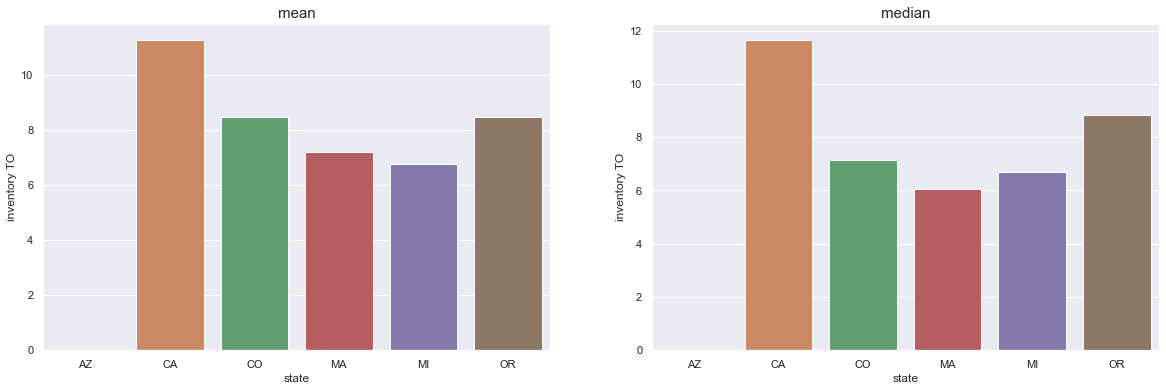

In [73]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="mean",ax=ax[0])

ax[0].set_title("mean", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="50%",ax=ax[1])

ax[1].set_title("median", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



Text(0, 0.5, 'inventory TO')

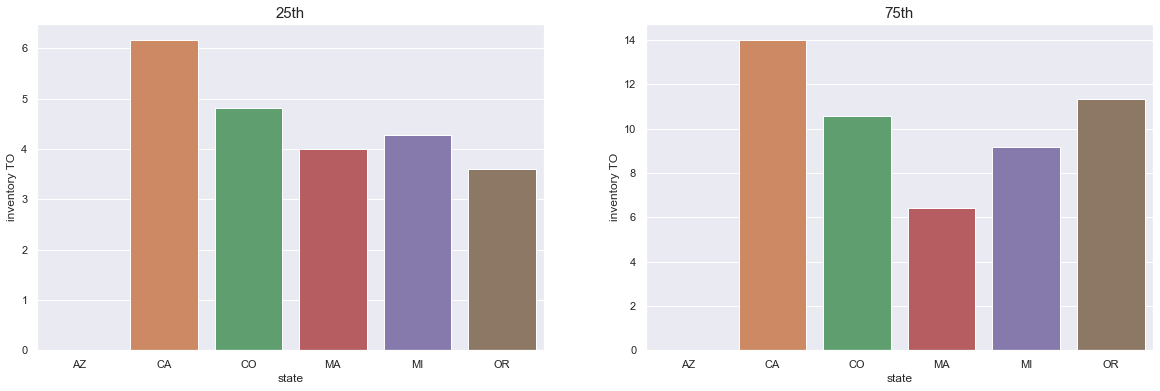

In [74]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="25%",ax=ax[0])

ax[0].set_title("25th", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="75%",ax=ax[1])

ax[1].set_title("75th", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



Text(0, 0.5, 'inventory TO')

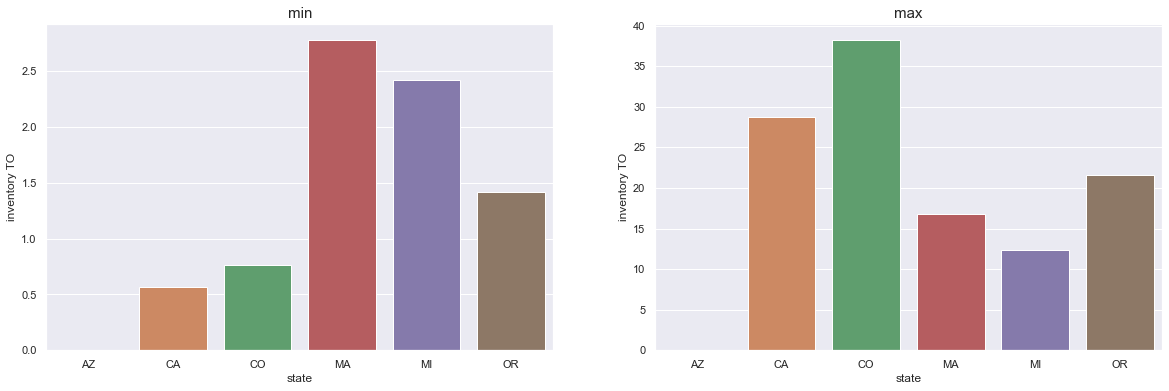

In [75]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="min",ax=ax[0])

ax[0].set_title("min", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="max",ax=ax[1])

ax[1].set_title("max", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



# THE END

In [ ]:
# gmv weighted avg
# assign an column that gives each location's gmv weight in its (month,state)
#final_df = final_df.groupby(['year_month','location_state']).apply(lambda df: df.assign(weight=df['subtotalInDollars'] / df['subtotalInDollars'].sum())).reset_index(drop=True)

#weighted_avg_margin_by_state = pd.DataFrame(final_df[['year_month','margin_perc','location_state','weight']].groupby(['location_state','year_month']).apply(lambda x: sum(x['weight']*x['margin_perc'])).reset_index())

#weighted_avg_margin_by_state['year_month'] = pd.to_datetime(weighted_avg_margin_by_state['year_month'])
#weighted_avg_margin_by_state.columns = ['location_state','year_month','margin_perc']

#line,ax = plt.subplots(figsize=(15,10))
#ax.set_title("monthly weighted avg margin by state", fontsize=15)
#ax.set_xlabel ("year month")
#ax.set_ylabel ("margin %")
#ax.legend (loc="upper right")
#sns.lineplot(data=weighted_avg_margin_by_state, x="year_month", y="margin_perc", hue="location_state",marker= 'o', markersize=9)



In [ ]:
"""
def pre_process_inv_df(df_sales,df_inv,loc_id,loc_state):
    df_sales = (
        df_sales
        .assign(**{"createdAt": lambda df_: pd.to_datetime(df_['createdAt'])})
        .assign(**{"year_month": lambda df_: df_['createdAt'].dt.strftime('%Y-%m')})
        .assign(**{"per_unit_price": lambda df_: df_['subtotalInDollars'] / df_['numberOfItems']})
        .assign(**{"per_unit_cost": lambda df_: df_['costInDollars'] / df_['numberOfItems']})
        #.replace('None', np.nan).fillna(0)
    )
    
    #exclude cost < $1.0
    df_low_cost = df_sales[df_sales['costInDollars'] < 1.0]
    df_non_low_cost = df_sales[df_sales['costInDollars'] >= 1.0]
    
    #exclude high unit sales price
    df_high_sale = df_non_low_cost[df_non_low_cost['per_unit_price'] > 500]
    df_non_high_sale =  df_non_low_cost[df_non_low_cost['per_unit_price'] <= 500]
    
    #exclude high unit cost 
    df_high_cost = df_non_high_sale[df_non_high_sale['per_unit_cost'] > 500]
    df_non_high_cost =  df_non_high_sale[df_non_high_sale['per_unit_cost'] <= 500]

    
    # calculate per sku per unit cost
    sku_avg_price = df_non_high_cost[['sku','per_unit_cost']].groupby(['sku']).mean().reset_index()
    sku_med_price = df_non_high_cost[['sku','per_unit_cost']].groupby(['sku']).median().reset_index()
    # merge inventory with per unit cost
    df_inv_to_merge = df_inv[['sku','quantity']]
    df_merged_avg = df_inv_to_merge.merge(sku_avg_price,on = 'sku', how = 'inner')
    df_merged_med = df_inv_to_merge.merge(sku_med_price,on = 'sku', how = 'inner')
    # calculate inventory
    inventory_avg = np.nansum(df_merged_avg['quantity'] * df_merged_avg['per_unit_cost'])
    inventory_med = np.nansum(df_merged_med['quantity'] * df_merged_med['per_unit_cost'])
    #calculate coverage at sku level
    coverage_avg = df_merged_avg['sku'].nunique() / df_inv_to_merge['sku'].nunique()
    coverage_med = df_merged_med['sku'].nunique() / df_inv_to_merge['sku'].nunique()
    final_df = pd.DataFrame([loc_id,loc_state,inventory_avg,coverage_avg,inventory_med,coverage_med]).T
    return final_df
    
    """

In [ ]:
## 1 company TdyAhrZWq6MDeyNvu: trimmed by accessory and cost > 1